# Séries Temporais

<br>

## Análise Inicial do Dataset

O dataset utilizado é o *Daily Climate time series data* ([presente aqui](https://www.kaggle.com/datasets/sumanthvrao/daily-climate-time-series-data)), que contém registros climáticos da cidade de Delhi, Índia, de 01/01/2013 até 24/04/2017, com amostras diárias. Suas 4 colunas são:

<br>

  - **date:** Representa o timestamp de cada amostra.

  - **meantemp:** Temperatura média calculada em vários intervalos de 3 horas em um dia (amostra).

  - **humidity:** Umidade relativa.

  - **wind_speed:** Velocidade do vento.

<br>

Não há valores nulos no dataset. Todas as colunas são do tipo `float64`, exceto a coluna **date**.

<br>

## Modificações e Tratamento Necessário

  - **Conversão de Datetime:** A coluna **date** precisa ser convertida para o tipo `datetime`.

  - **Indexação Temporal:** A coluna **date** será utilizada como índice, o que facilitará as operações temporais.

  - **Normalização de Variáveis:** Para garantir a eficácia do modelo de séries temporais, poderá ser necessário normalizar as colunas com variáveis numéricas.

  - **Criação de Lags:** Séries temporais envolvem a previsão com base em valores passados. Dessa forma, será necessário criar **lags** para as variáveis de consumo, o que implica deslocar os valores temporais para construir um modelo supervisionado.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

## Carregamento e Visualização dos Dados


In [15]:
df = pd.read_csv('/content/drive/MyDrive/Datasets/DailyDelhiClimateTrain.csv',
                 usecols='''date meantemp humidity wind_speed'''.split())

df.head()

,date,meantemp,humidity,wind_speed
0,2013-01-01,10.000000,84.500000,0.000000
1,2013-01-02,7.400000,92.000000,2.980000
2,2013-01-03,7.166667,87.000000,4.633333
3,2013-01-04,8.666667,71.333333,1.233333
4,2013-01-05,6.000000,86.833333,3.700000


## Tratamento e Pré-processamento dos Dados

  - **Conversão da Coluna date:** Como a série temporal depende de uma indexação correta de tempo, precisamos garantir que a coluna **date** esteja no tipo `datetime`.
  
  - **Indexação:** Transformar a coluna **date** em índice para facilitar o tratamento da série temporal.

  - **Normalização dos Dados:** fazer a normalização de todas as colunas com dados `float64` com o **MinMax Scaler** (intervalo [0, 1])

In [16]:
# Certificando-se de que a coluna 'date' está em formato datetime
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

# Definindo 'date' como índice do dataframe, assim como a frequência da série temporal
df = df.set_index('date').asfreq('1D')

# Ordenando o índice temporal
df.sort_index(inplace=True)

# Normalizando os dados
scaler = MinMaxScaler()
df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)

df.head()

,meantemp,humidity,wind_speed
date,,,
2013-01-01,0.122271,0.820957,0.000000
2013-01-02,0.042795,0.907591,0.070583
2013-01-03,0.035662,0.849835,0.109743
2013-01-04,0.081514,0.668867,0.029212
2013-01-05,0.000000,0.847910,0.087636


## Visualização Inicial

  - Análise visual inicial das variáveis climáticas para verificar tendências, sazonalidades ou padrões que possam existir ao longo do tempo.

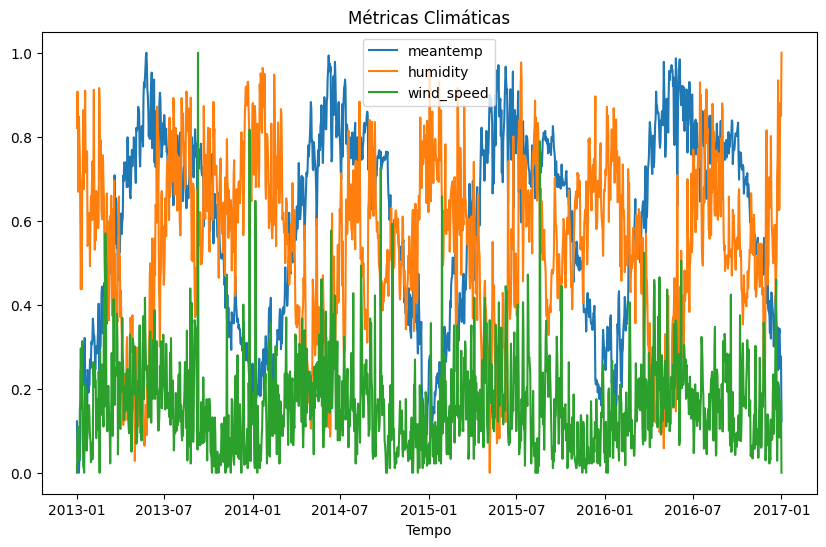

In [17]:
# Plotando as métricas climáticas de Delhi ao longo do tempo
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['meantemp'], label='meantemp')
plt.plot(df.index, df['humidity'], label='humidity')
plt.plot(df.index, df['wind_speed'], label='wind_speed')
plt.xlabel('Tempo')
plt.ylabel('')
plt.title('Métricas Climáticas')
plt.legend()
plt.show()

## Criação de Lags

- Em séries temporais, os valores passados são usados para prever valores futuros. Dessa forma, será criado **lags da variável de temperatura média** para transformá-la em um problema de aprendizado supervisionado.

In [18]:
# Criando lags para a temperatura média
df['lag_1'] = df['meantemp'].shift(1)
df['lag_2'] = df['meantemp'].shift(2)
df['lag_3'] = df['meantemp'].shift(3)
df['lag_4'] = df['meantemp'].shift(4)

# Removendo valores NaN criados pelos lags
df.dropna(inplace=True)

df[['meantemp', 'lag_1', 'lag_2', 'lag_3', 'lag_4']].head()

,meantemp,lag_1,lag_2,lag_3,lag_4
date,,,,,
2013-01-05,0.000000,0.081514,0.035662,0.042795,0.122271
2013-01-06,0.030568,0.000000,0.081514,0.035662,0.042795
2013-01-07,0.030568,0.030568,0.000000,0.081514,0.035662
2013-01-08,0.087336,0.030568,0.030568,0.000000,0.081514
2013-01-09,0.244541,0.087336,0.030568,0.030568,0.000000


## Divisão do dataset em Conjuntos Treinamento e Teste

  - Para manter a integridade temporal dos dados, a divisão entre treinamento e teste deve ser feita sequencialmente, sem embaralhamento.

  - Foi escolhido, inicialmente, uma proporção de **80-20**.

In [21]:
# Dividindo os dados entre conjuntos treinamento e teste (80-20)
train_size = int(0.8 * len(df))
test_size = len(df) - train_size

# Definindo as variáveis de entrada (lags) e a variável de saída (meantemp)
X = df[['lag_1', 'lag_2', 'lag_3', 'lag_4']]
y = df['meantemp']

# Dividindo dados de treino e teste com base no tempo
X_train, X_test = X[:train_size], X[:test_size]
y_train, y_test = y[:train_size], y[:test_size]

print(f'Tamanho do conjunto de treinamento: ( X_train -> {len(X_train)} // y_train -> {len(y_train)} )')
print(f'Tamanho do conjunto de teste: ( X_test -> {len(X_test)} // y_test -> {len(y_test)} )')

Tamanho do conjunto de treinamento: ( X_train -> 1166 // y_train -> 1166 )
Tamanho do conjunto de teste: ( X_test -> 292 // y_test -> 292 )


## Modelo Escolhido

  - A **Regressão Linear** é um modelo de aprendizado supervisionado que tenta modelar a relação entre uma variável dependente (ou alvo) e uma ou mais variáveis independentes (ou features) através de uma equação linear. No contexto de séries temporais, a Regressão Linear pode ser utilizada para prever valores futuros de uma série com base nos valores passados, que são representados pelos **lags** da variável.

In [22]:
from sklearn.linear_model import LinearRegression

# Definir e treinar o modelo de Regressão Linear
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Fazer previsões no conjunto de teste
forecast_lr = lr_model.predict(X_test)

## Avaliação do Modelo

  - Para avaliar o modelo, a métrica escolhida foi o **Erro Médio Quadrático (RMSE)**, que mede a diferença entre os valores previstos e os valores reais.

In [23]:
from sklearn.metrics import root_mean_squared_error

# Calcular o RMSE
error_lr = root_mean_squared_error(y_test, forecast_lr)
print(f'RMSE do Linear Regression Normalizado: {error_lr}')
print(f'\n O RMSE após a normalização com MinMaxScaler indica que, em média, '
      f'a diferença entre os valores previstos e os reais é ')
print(f'de {error_lr * 100:.2f}% (normalização foi feita no intervalo [0, 1]).')

RMSE do Linear Regression Normalizado: 0.05542459673317106

 O RMSE após a normalização com MinMaxScaler indica que, em média, a diferença entre os valores previstos e os reais é 
de 5.54% (normalização foi feita no intervalo [0, 1]).


## Visualização dos Resultados

  - Para facilitar a análise de desempenho das previsões do modelo, além do RMSE, aqui será feito o plot dos resultados previstos pelo modelo para facilitar a comparação com os dados reais do consumo de energia.

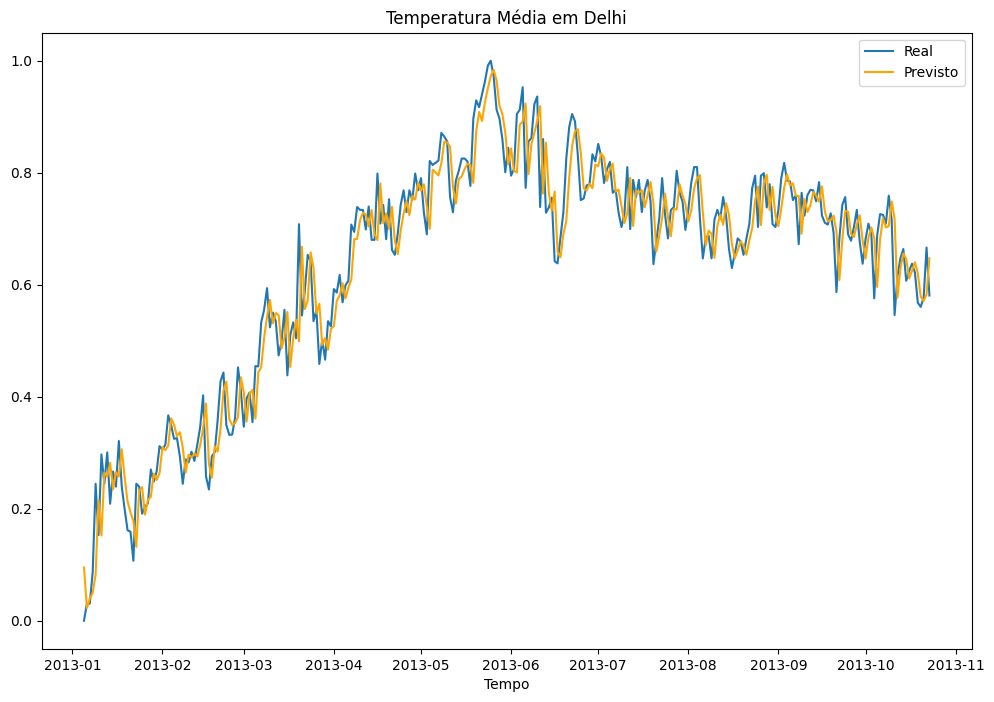

In [27]:
# Visualizar as previsões
plt.figure(figsize=(12, 8))
plt.plot(y_test.index, y_test, label='Real')
plt.plot(y_test.index, forecast_lr, label='Previsto', color='Orange')
plt.legend()
plt.title('Temperatura Média em Delhi')
plt.xlabel('Tempo')
plt.ylabel('')
plt.show()